In [1]:
import json
import math
from collections import Counter
from augur.utils import json_to_tree
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import pandas as pd

## Figure 4: Egg-adaptive mutations change over time

In [2]:
def get_muts(virus, segment, gene):
    """
    Return all nonsyn muts in this gene
    """
    
    curated_mut_file = f"../egg-mutation-analysis/egg-muts-by-strain/{virus}_{segment}_curated-egg-muts.json"
    
    with open(curated_mut_file) as json_handle:
        egg_mut_info = json.load(json_handle)
        
    muts_by_strain = {}
        
    for strain, muts in egg_mut_info.items():
        
        muts_by_strain[strain] = muts.get(gene, [])

    return muts_by_strain

In [3]:
def get_strain_year(virus, segment):
    """
    Return the year for all egg-passaged strains, 
    and also for all other strains (so we can determine what percentage are egg-passaaged)
    """

    tree_path= f'../nextstrain_builds/egg-enriched/auspice/{virus}_{segment}_egg.json'
    
    #read in the tree
    with open(tree_path, 'r') as f:
        tree_json = json.load(f)
        
    #put tree in Bio.phylo format
    tree = json_to_tree(tree_json)
    
    eggstrains_to_year = {}
    
    for node in tree.find_clades(terminal=True):
        passage = node.node_attrs['passage_category']['value']
        date = node.node_attrs['num_date']['value']
        year = math.trunc(date)
        if passage == 'egg':
            eggstrains_to_year[node.name] = year
#         else:
#             otherstrains_to_year[node.name] = year
            
    return eggstrains_to_year

In [4]:
def get_muts_in_windows(virus, segment, gene, window_len, sites):
    """
    Partition all strains into sliding time windows and find the percentage of strains in that window
    with each mutation
    Can specify whether to do this for just certain sites, or for entire gene
    """
    
    # get date for each strain
    eggstrains_to_year = get_strain_year(virus, segment)
    
    # get aa muts in this gene for each strain
    muts_by_strain = get_muts(virus, segment, gene)
    
    # make sliding windows
    max_year = max(eggstrains_to_year.values())
    min_year = min(eggstrains_to_year.values())
    
    all_years = years = list(range(min_year, max_year + 1))
    windows = [all_years[i:i + window_len] for i in range(len(all_years) - window_len + 1)]
    
    # keep track of muts at egg adaptive sites in each window
    # as percentage of all egg-strains in that window
    res_muts_all_windows_pct = {}
    aa_muts_all_windows_pct = {}
    
    # and also as a count
    res_muts_all_window_count = {}
    aa_muts_all_window_count = {}
    
    # total number of egg strains in window
    eggstrains_per_window = {}
    
    # find egg_muts in this window
    for window in windows:
        # number of times each residue has recieved mut in the window
        res_muts_in_window = []
        # count of each mut within the window
        aa_muts_in_window = []
        
        # get all strains in window
        eggstrains = [k for k,v in eggstrains_to_year.items() if v in window]
        
        # require at least 5 egg strains per window
        if len(eggstrains)>=5:
        
            # get aa muts in these strains
            muts_in_window = []
            for e in eggstrains:
                # if looking at all muts in gene
                if sites == 'gene':
                    aa_muts_in_window += muts_by_strain[e]
                    res_muts_in_window += [x[:-1] for x in muts_by_strain[e]]
                else:
                    muts_in_site_list = [x for x in muts_by_strain[e] if int(x[:-1]) in sites]
                    aa_muts_in_window += muts_in_site_list
                    res_muts_in_window += [x[:-1] for x in muts_in_site_list]

            # count number of egg strains that got particular muts in this window
            res_muts_in_window_count = Counter(res_muts_in_window)
            # or number of egg strains with muts at particular residue
            aa_muts_in_window_count= Counter(aa_muts_in_window)      

            # convert to percentage of all strains in window
            res_muts_in_window_pct = {m:c/len(eggstrains) for m,c in res_muts_in_window_count.items()}
            # convert to percentage of all strains in window
            aa_muts_in_window_pct = {m:c/len(eggstrains) for m,c in aa_muts_in_window_count.items()}


            # store muts in this window by its midpoint
            window_midpoint = sum(window)/len(window)

            eggstrains_per_window[window_midpoint] = len(eggstrains)


            res_muts_all_windows_pct[window_midpoint] = res_muts_in_window_pct
            aa_muts_all_windows_pct[window_midpoint] = aa_muts_in_window_pct
            res_muts_all_window_count[window_midpoint] = res_muts_in_window_count
            aa_muts_all_window_count[window_midpoint] = aa_muts_in_window_count

            
        

        
    return (res_muts_all_windows_pct, aa_muts_all_windows_pct, 
            res_muts_all_window_count, aa_muts_all_window_count, eggstrains_per_window)
    
    

In [6]:
def limit_to_x_occurrence(virus, segment, gene, window_len, adaptive_sites, threshold):
    """
    Return the percentage of egg strains with an "adaptive" mutation at the given residues
    Where an adaptive mut needs to have occurred threshold or more times (overall, not necessarily just in window)
    """
    
    
    (res_muts_all_windows_pct, aa_muts_all_windows_pct, res_muts_all_window_count, 
     aa_muts_all_window_count, eggstrains_per_window) = get_muts_in_windows(virus, segment, gene, window_len, adaptive_sites)
    
    aas_at_sites= get_predominant_aas(virus, segment, gene, adaptive_sites)
    #limit to just aas observed at least "theshold" number of times
    aas_over_threshold = {int(res):{aa:c for aa,c in aa_counts.items() if c>=threshold} for res, aa_counts in aas_at_sites.items()}

    # keep track of number of adaptive muts (occurring more than X times) at each of the specified residue sites
    num_adaptive_muts_at_residue_by_window = {y:{x:0 for x in adaptive_sites} for y in eggstrains_per_window.keys()}
    
    for y, d in aa_muts_all_window_count.items():
        for a, c in d.items():
            s = int(a[:-1])
            aa = a[-1]
            if aa in aas_over_threshold[s]:
                num_adaptive_muts_at_residue_by_window[y][s]+=c
    
    pct_adaptive_muts_at_residue_by_window = {y:{x:c/eggstrains_per_window[y] for x,c in d.items()} for y,d in num_adaptive_muts_at_residue_by_window.items()}
                
    return pct_adaptive_muts_at_residue_by_window

In [21]:
def get_muts_over_threshold(virus, segment, gene, threshold):
    """
    Return all muts over the threshold
    """
    
    muts_file = f"../egg-mutation-analysis/egg-mut-counts/{virus}_{segment.upper()}_{gene.upper()}_egg-mut-counts.json"
    
    with open(muts_file) as json_handle:
        egg_mut_info = json.load(json_handle)
    
    
    sites_over_threshold = list(egg_mut_info[f'sites_mutated_above_{threshold}percent'].keys())
                
    
    return sites_over_threshold
        

In [81]:
# store the sites that are adaptive from overall analysis
ha1_egg_adaptive_sites_overall = {}
for v in ['h3n2', 'h1n1pdm', 'vic', 'yam']:
    ha1_egg_adaptive_sites_overall[v] = [int(x) for x in get_muts_over_threshold(v, 'ha', 'ha1', 3)]

In [86]:
def get_transient_adaptive_sites(virus, segment, gene, window_len):
    """
    Look for sites that get mutated in egg strains during just a period of time (and don't show up in the overall list) 
    Let's say they have to be present in over 3% of strains within a 5-year period
    """
    
    (res_muts_all_windows_pct, aa_muts_all_windows_pct, res_muts_all_window_count, 
     aa_muts_all_window_count, eggstrains_per_window) = get_muts_in_windows(virus, segment, gene, window_len, 'gene')
    
    mut_res_by_window = {y:[] for y in res_muts_all_windows_pct.keys()}
        
    for y, d in aa_muts_all_windows_pct.items():
        for m, p in d.items():
            if p>=0.03:
                mut_res_by_window[y].append(m)
                
    muts_not_in_overall = {y:[x for x in r if int(x[:-1]) not in ha1_egg_adaptive_sites_overall[virus]] for y,r in mut_res_by_window.items()}
    # find those that appear in at least 5 windows
    window_counts = Counter([x for l in list(muts_not_in_overall.values()) for x in l])
    
    transient_muts = [m for m,c in window_counts.items() if c>=6]
    
    return transient_muts
    

In [87]:
# kind of manually assess whether these look "real" egg-adaptive mutations
# will need to explain this in the text.
# some of these transient mutations look real, but I feel less confident particularly about the ones that occur
# in late 90s because many non-egg strains have them too. Those could be mislabeled I suppose? 
# Or not true egg-adaptation


# fpr h1n1pdm: 224K looks real, and maybe 190R and 183P too, but these don't come up

transient_adaptive_sites = {'h3n2': [int(x[:-1]) for x in get_transient_adaptive_sites('h3n2', 'ha', 'HA1', 5)],
                            'h1n1pdm': [int(x[:-1]) for x in get_transient_adaptive_sites('h1n1pdm', 'ha', 'HA1', 5)], 
                            'vic': [int(x[:-1]) for x in get_transient_adaptive_sites('vic', 'ha', 'HA1', 5)], 
                            'yam': [int(x[:-1]) for x in get_transient_adaptive_sites('yam', 'ha', 'HA1', 5)]}


In [71]:
def get_predominant_aas(virus, segment, gene, sites):
    """
    Return count of all aas that are seen at the sites, ordered by number of occurrences
    """
    
    # muts in each strain
    muts_by_strain = get_muts(virus, segment, gene)
    
    # keep track of aa identity of all observed muts
    aas_by_res = {str(x):[] for x in sites}
    
    for s, ms in muts_by_strain.items():
        for m in ms:
            res = m[:-1]
            aa = m[-1]
            if int(res) in sites:
                aas_by_res[res].append(aa)
                
    # now count aas
    # order by most prevalent
    aa_counts_by_res = {x:dict(Counter(a).most_common()) for x,a in aas_by_res.items()}
    
    
    
    return aa_counts_by_res
    

In [72]:
# set aas to manually exclude (not convinced they are adaptive based on tree)
manual_exclude = {'h3n2': {186:['D', 'R']}}

In [92]:
def plot_aa_muts_over_time(virus, segment, gene, window_len, res, threshold, ax, include_x_ticks=True, y_axis='pct'):
    """
    For a given site, plot the amino acid muts that are observed there over time 
    as a lineplot showing frequency of mut
    """
    
    # find all aas that are observed 10 or more times
    # look at the adaptive residues from the overall analysis (Fig3) plus temporal analysis above
    adaptive_sites = ha1_egg_adaptive_sites_overall[virus] + transient_adaptive_sites[virus]
    aa_counts_by_res = get_predominant_aas(virus, segment, gene, adaptive_sites)
    aas_at_res = [x for x,c in aa_counts_by_res[res].items() if c>=threshold]
    if virus in manual_exclude.keys():
        if int(res) in manual_exclude[virus].keys():
            aas_at_res = [x for x in aas_at_res if x not in manual_exclude[virus][int(res)]]

            
        
    # get info on prevalence of muts in each time window
    (res_muts_all_windows_pct, aa_muts_all_windows_pct, res_muts_all_window_count, 
     aa_muts_all_window_count, eggstrains_per_window) = get_muts_in_windows(virus, segment, gene, window_len, adaptive_sites)
    
    
    aa_pcts_by_window = []
    if y_axis == 'pct':
        df = aa_muts_all_windows_pct
    elif y_axis == 'count':
        df = aa_muts_all_window_count
    for y, d in df.items():
        for m, p in d.items():
            r = m[:-1]
            aa = m[-1]
            if r == res:
                if aa in aas_at_res:
                    aa_pcts_by_window.append({'window_midpoint':y, 'aa': aa, 'y': p})
    
    to_plot = pd.DataFrame(aa_pcts_by_window)
    
    # map each aa to a different color
    all_amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
    color_palette = sns.color_palette("tab20", 20)
    cmap = {aa: color for aa, color in zip(all_amino_acids, color_palette)}
    
    ## if coloring all aas different shades of green
#     aa_mut_colors = ['#00c88a', '#006e5e', '#9ee79e', '#006646']    
#     cmap = {a:aa_mut_colors[i] for i, a in enumerate(aas_at_res)}

    
    sns.lineplot(data=to_plot, x='window_midpoint', y='y', hue='aa', palette=cmap, ax=ax, legend=False)
    
    # label the position
    if virus in ['vic', 'yam']:
        ax.text(0.05, 0.95, res, fontsize=14, transform=ax.transAxes)

    else:
        ax.text(0.05, 0.85, res, fontsize=14, transform=ax.transAxes)
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    # set x-axis to cover entire span, even if the frequencies for this mut do not
    if virus=='h1n1pdm':
        ax.set_xlim(2009, 2024)
        ax.set_xticks(range(2009, 2025, 5))
    elif virus == 'vic':
        ax.set_xlim(2000, 2024)
        ax.set_xticks(range(2000, 2025, 10))
    elif virus == 'yam':
        ax.set_xlim(1994, 2020)
        ax.set_xticks(range(1994, 2020, 10))
    else:
        ax.set_xlim(1994, 2024)
        ax.set_xticks(range(1994, 2025, 10))
        
    if include_x_ticks==False:
        ax.set_xticklabels([])
        
    ax.tick_params(axis='y', labelsize=10)

    
    sns.despine()
                
    


In [74]:
virus_cmap = {'yam': '#fbba0a', 'vic': '#FF4500', 'h3n2': '#6C3BAA', 'h1n1pdm': '#45b6fe'}


In [97]:
def plot_muts_per_window(virus, segment, gene, window_len, threshold, ax):
    """
    Plot a heatmap of the proporotion of egg strains that get a mut at each adaptive residue over time
    """
    # get adaptive sites
    adaptive_sites = ha1_egg_adaptive_sites_overall[virus] + transient_adaptive_sites[virus]

#     (res_muts_all_windows_pct, aa_muts_all_windows_pct, res_muts_all_window_count, 
#      aa_muts_all_window_count, eggstrains_per_window) = get_muts_in_windows(virus, segment, gene, window_len, adaptive_sites)
    pct_adaptive_muts_at_residue_by_window = limit_to_x_occurrence(virus, segment, gene, window_len, adaptive_sites, threshold)
    
    # make df of pct of egg strains with mut at residue 
    # only considering aa muts occuring at least threshold number of times
    to_df = []
    for y, d in pct_adaptive_muts_at_residue_by_window.items():
        for r, p in d.items():
            to_df.append({'year': math.trunc(float(y)), 'residue': r, 'pct_w_mut': p})
            
    df = pd.DataFrame(to_df).pivot(index='residue', columns='year', values='pct_w_mut')
        
    aspect = {'h3n2': 25, 'h1n1pdm': 12.5, 'vic': 6.25, 'yam': 6.25}
    
    sns.heatmap(df, cmap=sns.light_palette(virus_cmap[virus], as_cmap=True), ax=ax, 
                cbar_kws={'aspect': aspect[virus]})
    
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    # add the adaptive AA to y-axis. Or say that there are many
    # for adaptive aas, this is any that appear at least threshold number of times
    aas_count = get_predominant_aas(virus, segment, gene, adaptive_sites)
    adaptive_aas = {int(k):[a for a,c in v.items() if c>=threshold] for k,v in aas_count.items()}
    # manual exclude of aas that aren't convincingly adaptive
    if virus in manual_exclude.keys():
        for res, aas in adaptive_aas.items():
            if int(res) in manual_exclude[virus].keys():
                aas_at_res = [x for x in aas if x not in manual_exclude[virus][int(res)]]
                adaptive_aas[res] = aas_at_res
    
    updated_labels = []
    for label in ax.get_yticklabels():
        residue = int(label.get_text())  # Get the residue number from the label
        label.set_color('black')  
        # change text of label according to the adaptive AAs   
        if len(adaptive_aas[residue])==1:
            aa_text = adaptive_aas[residue][0]
        else:
            aa_text = "/".join(adaptive_aas[residue])

        label_text = f'{residue} {aa_text}'
            
        updated_labels.append(label_text)

    ax.set_yticklabels(updated_labels, rotation=0)

    
    return ax

In [76]:
def plot_aa_legend(ax):
    """
    Make the legend showing what color each aa is 
    """
    plt.rcParams['font.family'] = 'Arial'
    # map each aa to a different color
    all_amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

    color_palette = sns.color_palette("tab20", 20)

    cmap = {aa: color for aa, color in zip(all_amino_acids, color_palette)}
    
    # make a legend line for each aa
    aa_color_lines = [Line2D([0], [0], color=cmap[aa], lw=2) for aa in all_amino_acids]
    
    ax.legend(aa_color_lines, all_amino_acids, ncol=2, labelspacing=0.25, title='Amino acid', fontsize=8, 
              bbox_to_anchor=(1, 1))
            
    ax.yaxis.set_visible(False) 
    ax.spines['left'].set_color('white')
    
    ax.xaxis.set_visible(False) 
    ax.spines['bottom'].set_color('white')
    
    sns.despine()
            
    return ax
    

In [95]:
def plot_fig4(segment='ha', gene='HA1', window_len=3, threshold=8, filename=None):
    """
    """
    
    #plot styling
    sns.set_style("white")
    plt.rcParams['figure.dpi']= 300
    plt.rcParams['font.family'] = 'Arial'
    
    fig = plt.figure(figsize=(10, 10))
    # plot heatmap of all muts on left and then freqencies of specific muts on right
    # add row for blank space between viruses
    gs = GridSpec(11, 4, width_ratios=[3,1.25,0.025, 1.25], height_ratios=[1,1,1,1, 0.75, 1,1, 0.75, 1, 0.75, 1])
    
    # row 1 is H3N2
    # heatmap
    ax1 = fig.add_subplot(gs[0:4, 0])
    plot_muts_per_window('h3n2', segment, gene, window_len, threshold, ax1)
    ax1.text(-0.15, 1.02, 'A', fontsize=20, transform=ax1.transAxes)
    ax1.text(0.02, 1.02, 'A/H3N2', fontsize=14, transform=ax1.transAxes)

    
    # plot freq over time for specific h3n2 muts
    ax1_1 = fig.add_subplot(gs[0, 1])
    plot_aa_muts_over_time('h3n2', segment, gene, window_len, '156' , threshold, ax1_1, False)
    ax1_2 = fig.add_subplot(gs[1, 1])
    plot_aa_muts_over_time('h3n2', segment, gene, window_len, '160', threshold, ax1_2, False)
    ax1_3 = fig.add_subplot(gs[2, 1])
    plot_aa_muts_over_time('h3n2', segment, gene, window_len, '186', threshold, ax1_3, False)
    ax1_4 = fig.add_subplot(gs[3, 1])
    plot_aa_muts_over_time('h3n2', segment, gene, window_len, '190', threshold, ax1_4, True)
    ax1_5 = fig.add_subplot(gs[0, 3])
    plot_aa_muts_over_time('h3n2', segment, gene, window_len, '194', threshold, ax1_5, False)
    ax1_6 = fig.add_subplot(gs[1, 3])
    plot_aa_muts_over_time('h3n2', segment, gene, window_len, '219', threshold, ax1_6, False)
    ax1_7 = fig.add_subplot(gs[2, 3])
    plot_aa_muts_over_time('h3n2', segment, gene, window_len, '225', threshold, ax1_7, False)
    ax1_8 = fig.add_subplot(gs[3, 3])
    plot_aa_muts_over_time('h3n2', segment, gene, window_len, '246', threshold, ax1_8, True)
    
    # h1n1pdm heatmap
    ax2 = fig.add_subplot(gs[5:7, 0])
    plot_muts_per_window('h1n1pdm', segment, gene, window_len, threshold, ax2)
    ax2.text(-0.15, 1.02, 'B', fontsize=20, transform=ax2.transAxes)
    ax2.text(0.02, 1.02, 'A/H1N1pdm', fontsize=14, transform=ax2.transAxes)

    
    # plot freq over time for specific h1n1pdm muts
    ax2_1 = fig.add_subplot(gs[5, 1])
    plot_aa_muts_over_time('h1n1pdm', segment, gene, window_len, '187', threshold, ax2_1, False)
    ax2_2 = fig.add_subplot(gs[6, 1])
    plot_aa_muts_over_time('h1n1pdm', segment, gene, window_len, '222', threshold, ax2_2, True)
    # plot a legend showing what color each aa is
    ax2_3 = fig.add_subplot(gs[5:7, 3])
    plot_aa_legend(ax2_3)
    
    # vic heatmap
    ax3 = fig.add_subplot(gs[8, 0])
    plot_muts_per_window('vic', segment, gene, window_len, threshold, ax3)
    ax3.text(-0.15, 1.02, 'C', fontsize=20, transform=ax3.transAxes)
    ax3.text(0.02, 1.02, 'B/Vic', fontsize=14, transform=ax3.transAxes)

    
    # plot freq over time for specific vic muts
    ax3_1 = fig.add_subplot(gs[8, 1])
    plot_aa_muts_over_time('vic', segment, gene, window_len, '196', threshold, ax3_1, True)
    ax3_2 = fig.add_subplot(gs[8, 3])
    plot_aa_muts_over_time('vic', segment, gene, window_len, '198', threshold, ax3_2, True)
    
    # yam heatmap
    ax4 = fig.add_subplot(gs[10, 0])
    plot_muts_per_window('yam', segment, gene, window_len, threshold, ax4)
    ax4.text(-0.15, 1.02, 'D', fontsize=20, transform=ax4.transAxes)
    ax4.text(0.02, 1.02, 'B/Yam', fontsize=14, transform=ax4.transAxes)
    
    # plot freq over time for specific vic muts
    ax4_1 = fig.add_subplot(gs[10, 1])
    plot_aa_muts_over_time('yam', segment, gene, window_len, '195', threshold, ax4_1, True)
    ax4_2 = fig.add_subplot(gs[10, 3])
    plot_aa_muts_over_time('yam', segment, gene, window_len, '197', threshold, ax4_2, True)

    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=False, facecolor='white')
    

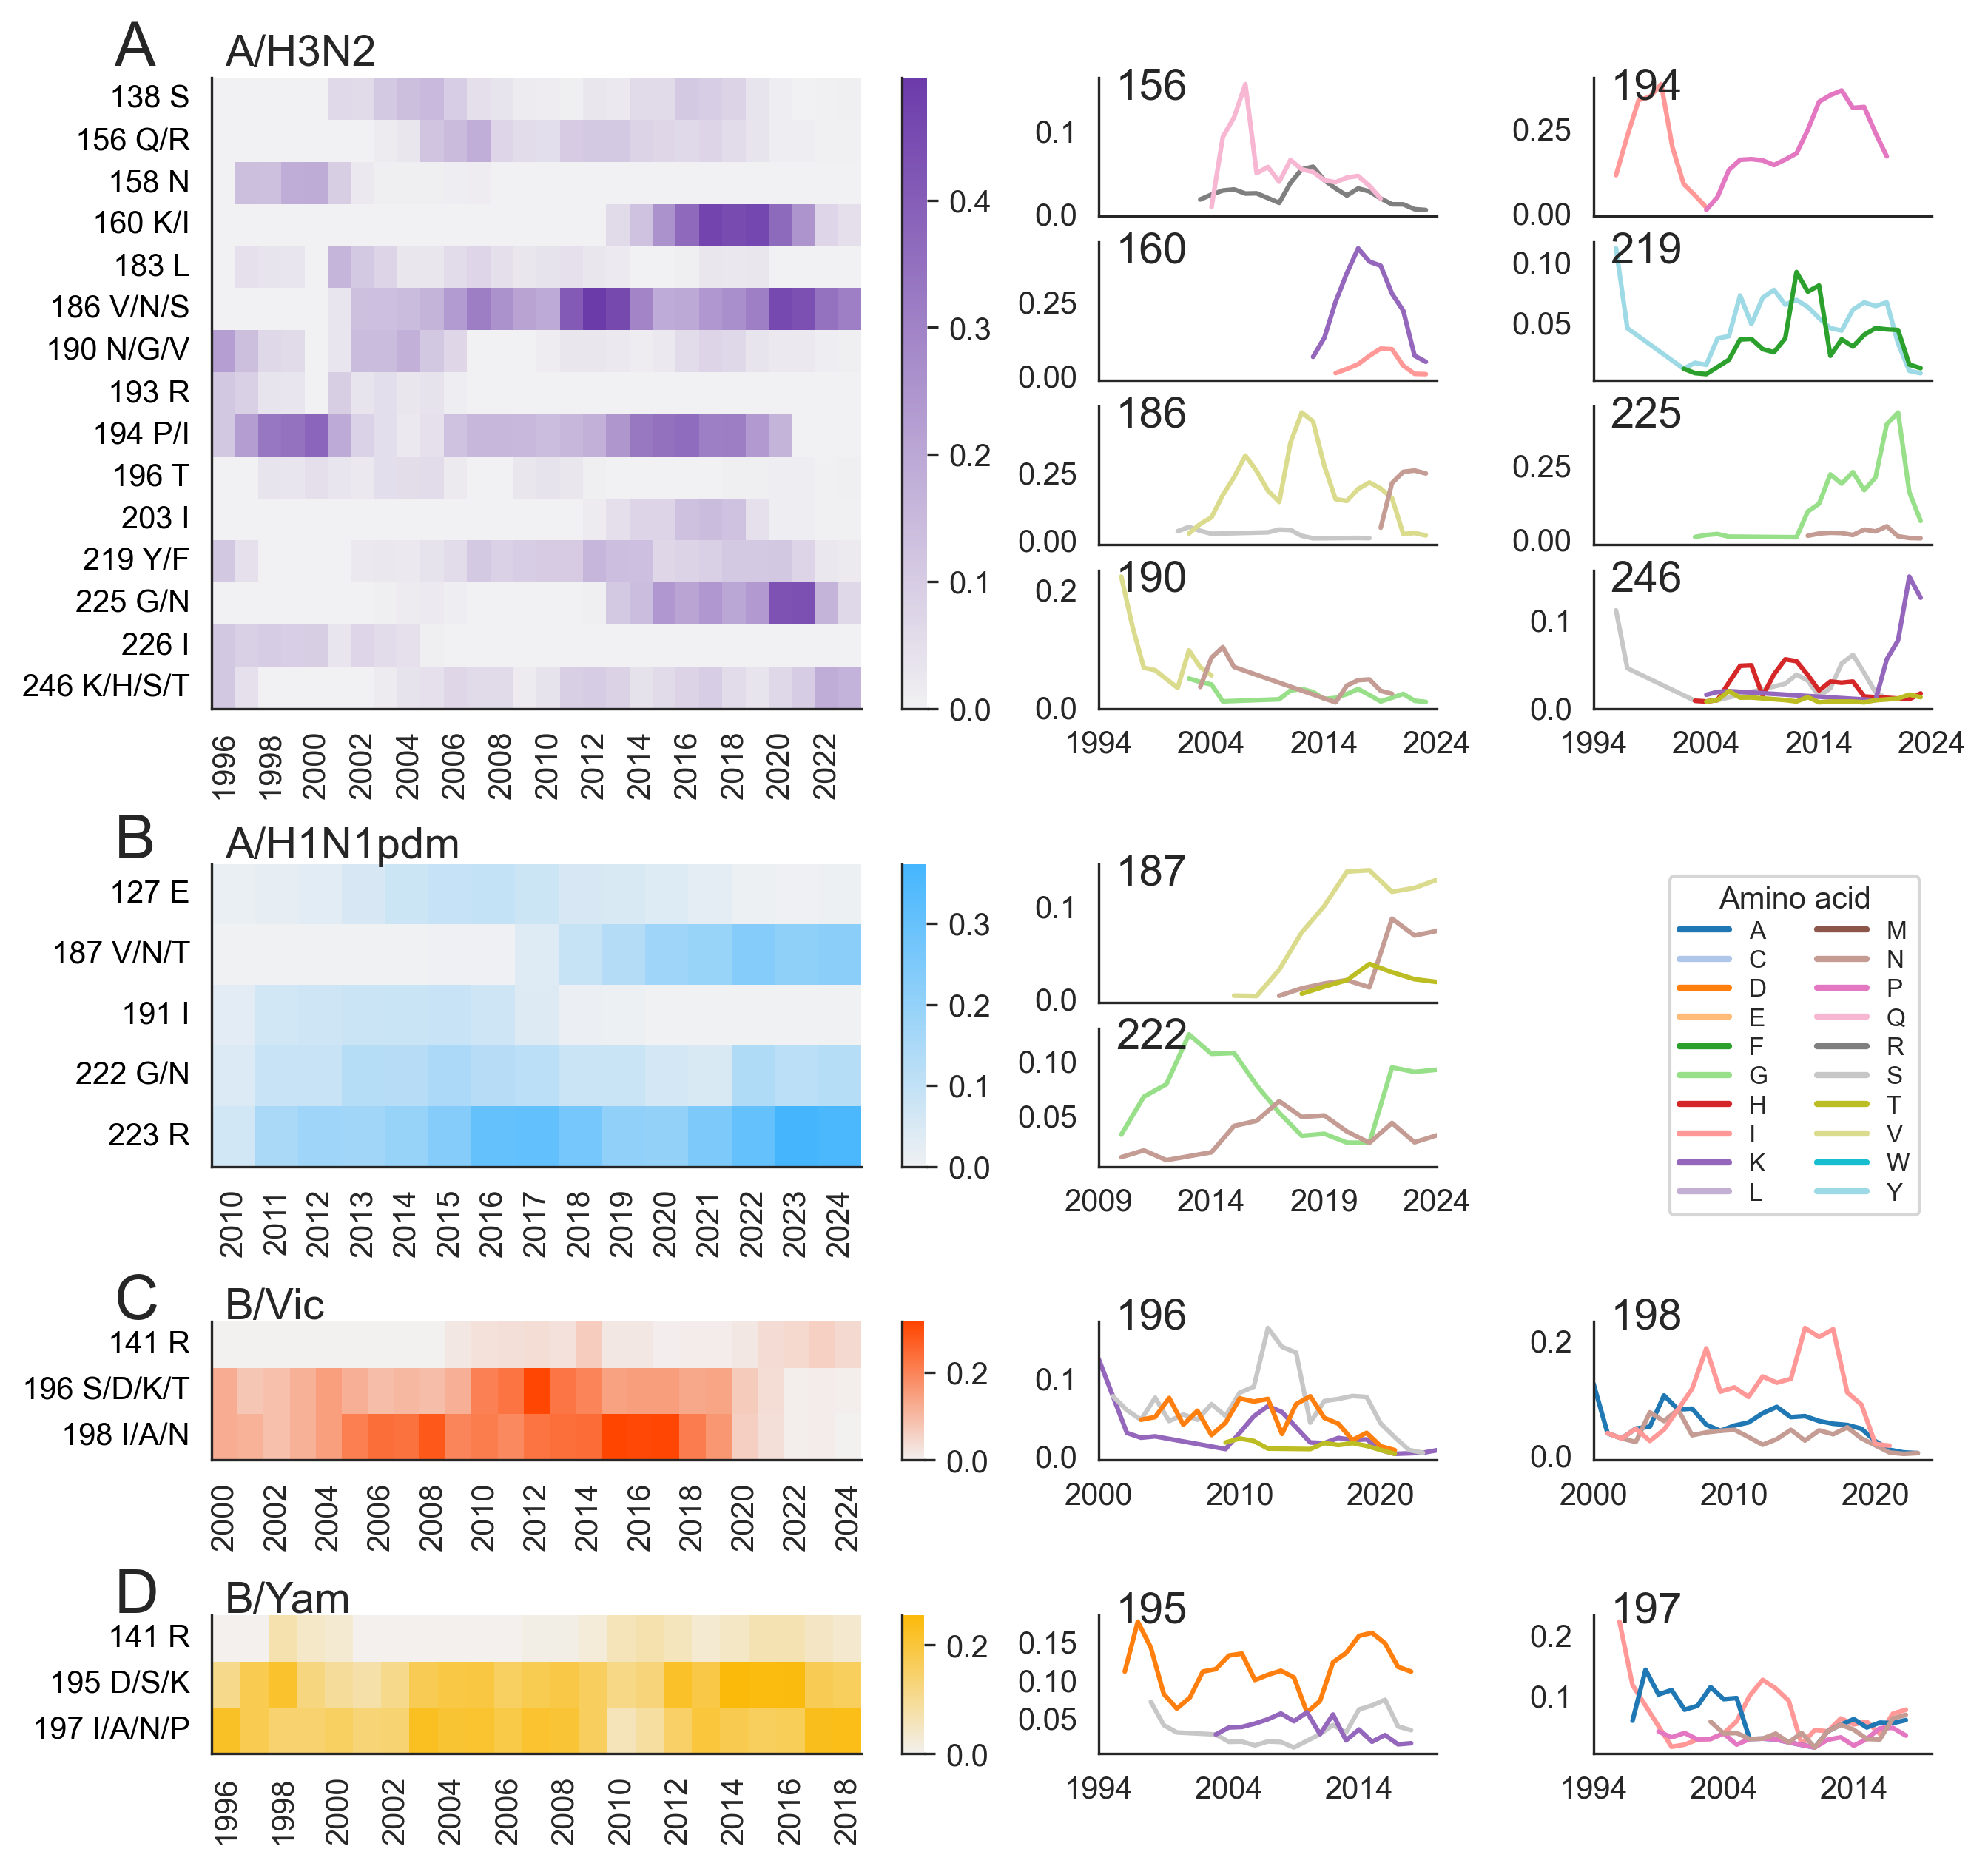

In [98]:
plot_fig4(filename='Figure4/Figure4.png')